In [1]:
import os
import sys
sys.path.append('/Users/wangqiqian/Desktop/TrafficTDApython/')

current_dir_path = os.getcwd()
current_file_path = os.path.abspath(current_dir_path)
current_dir_path = os.path.dirname(current_file_path)
parent_dir_path = os.path.dirname(current_dir_path)

# os.chdir(current_dir_path + '\\ultils')
os.chdir(current_dir_path + '/ultils')
print(current_dir_path)

import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering

from functions import *
from chi import *
from regressionP import *
from models import *
from utils_v3 import *

os.chdir('/Users/wangqiqian/Desktop/TrafficTDApython/')
# os.chdir('C:/Users/USER/Desktop/TrafficTDApython/')

from Version3.tdamapper.core import MapperAlgorithm
from Version3.tdamapper.cover import CubicalCover
from Version3.tdamapper.clustering import FailSafeClustering
from Version3.tdamapper.plot import MapperLayoutInteractive

/Users/wangqiqian/Desktop/TrafficTDApython


In [2]:
data1 = pd.read_csv("Data/NPA_TMA2_1.csv", low_memory=False)[:-2]
data2 = pd.read_csv("Data/NPA_TMA2_2.csv", low_memory=False)[:-2]
data3 = pd.read_csv("Data/NPA_TMA2_3.csv", low_memory=False)[:-2]
data4 = pd.read_csv("Data/NPA_TMA2_4_new.csv", low_memory=False)[:-2]
data5 = pd.read_csv("Data/NPA_TMA2_5.csv", low_memory=False)[:-2]
data6 = pd.read_csv("Data/NPA_TMA2_6_new.csv", low_memory=False)[:-2]
data7 = pd.read_csv("Data/NPA_TMA2_7.csv", low_memory=False)[:-2]
data8 = pd.read_csv("Data/NPA_TMA2_8.csv", low_memory=False)[:-2]
data9 = pd.read_csv("Data/NPA_TMA2_9.csv", low_memory=False)[:-2]
data10 = pd.read_csv("Data/NPA_TMA2_10.csv", low_memory=False)[:-2]

dataA2 = pd.concat([data1, data2, data3, data4, data5, data6, data7, data8, data9, data10], ignore_index=True)
# dataA2 = pd.concat([data1, data2, data3, data4, data5], ignore_index=True)

dataA1 = pd.read_csv("Data/NPA_TMA1_V3.csv")[:-2]

In [7]:
select_lst = [
    '道路類別-第1當事者-名稱', '速限-第1當事者', '道路型態大類別名稱', '道路型態子類別名稱',
    '事故位置大類別名稱', '事故位置子類別名稱', '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱', '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分向設施大類別名稱', '車道劃分設施-分向設施子類別名稱', '車道劃分設施-分道設施-快車道或一般車道間名稱',
    '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱', '事故類型及型態大類別名稱',
    '事故類型及型態子類別名稱', '死亡受傷人數',
    '肇因研判子類別名稱-個別'
    # '經度', '緯度'
]
print(len(select_lst))

def preprocess(input_data, select_lst):
    
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)
    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)
# Concat
rbind_data = pd.concat([dist_dfA1, dist_dfA2], axis=0, ignore_index=True)
assert rbind_data.shape[0] == dist_dfA1.shape[0] + dist_dfA2.shape[0]
# Dummy
rbind_data["速限-第1當事者"] = rbind_data["速限-第1當事者"].astype(str)
dummy_data = pd.get_dummies(rbind_data)

print(dummy_data.shape)

data_to_map = dummy_data.drop(['死亡', '受傷'], axis=1)
mapper_numpy = data_to_map.to_numpy()

23
(312760, 322)


In [41]:
import prince

MCA_X = rbind_data.drop(['死亡', '受傷'], axis=1)

mca = prince.MCA(
    one_hot=False,
    n_components=7,
    n_iter=30,
    copy=True,
    check_input=True,
    random_state=42
)

mca.fit(data_to_map)
# 回傳mca.row_coordinates(data_to_map)
lens = mca.transform(data_to_map)

print(mca.eigenvalues_summary)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.259         1.91%                      1.91%
1              0.182         1.34%                      3.26%
2              0.166         1.23%                      4.48%
3              0.146         1.08%                      5.56%
4              0.130         0.96%                      6.52%
5              0.118         0.87%                      7.40%
6              0.109         0.81%                      8.20%


In [22]:
col_coordinate = mca.column_coordinates(data_to_map)# 輸入為dummy後的資料
col_coordinate[col_coordinate[1] > 10]

,0,1,2,3,4,5,6
速限-第1當事者_15.0,0.166849,10.452720,0.601584,0.251471,0.326086,-0.628932,0.248569
道路型態大類別名稱_平交道,-0.428842,140.783815,19.646950,9.670874,-1.988613,1.873988,0.435016
道路型態子類別名稱_有遮斷器,-0.428842,140.783815,19.646950,9.670874,-1.988613,1.873988,0.435016
事故類型及型態大類別名稱_平交道事故,-1.207262,296.627060,46.166761,26.353480,-7.406868,8.880609,-0.445809
事故類型及型態子類別名稱_正越過平交道中,-1.233904,296.281317,46.907905,27.177418,-7.910274,9.640019,-0.533040
事故類型及型態子類別名稱_衝過(或撞壞)遮斷器,-1.193941,296.799932,45.796189,25.941510,-7.155166,8.500904,-0.402193
肇因研判子類別名稱-個別_搶(闖)越平交道,-1.207262,296.627060,46.166761,26.353480,-7.406868,8.880609,-0.445809


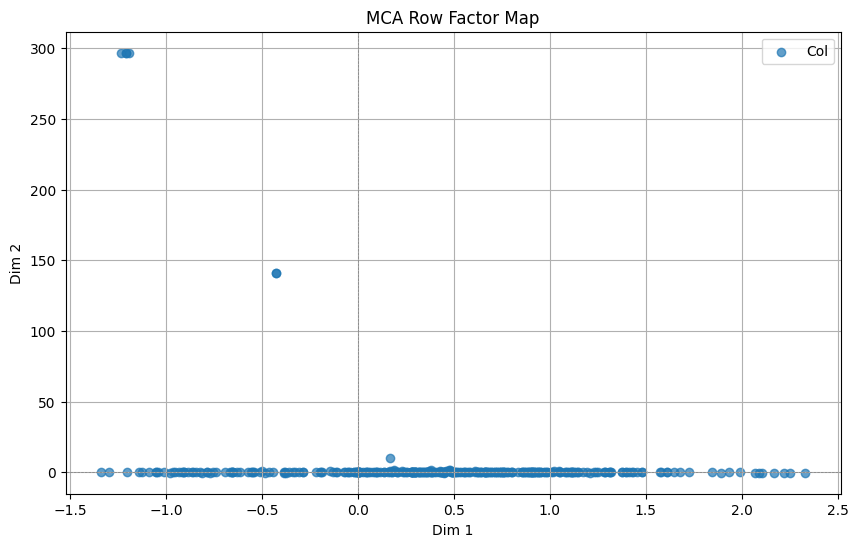

In [42]:
col_coordinate = mca.column_coordinates(data_to_map)
# col_coordinate = col_coordinate[col_coordinate[1] < 10]
plt.figure(figsize=(10, 6))
plt.scatter(col_coordinate[0], col_coordinate[1], alpha=0.7, label="Col")

# Label the plot
plt.axhline(0, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(0, color='grey', linestyle='--', linewidth=0.5)
plt.title("MCA Row Factor Map")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.legend()
plt.show()

In [26]:
detailed_results = []

for overlap in range(3, 6):
    silhouette_for_intervals = []

    for interval in range(5, 11):

        print(f'overlap: {overlap}, interval: {interval}')
        mapper_algo = MapperAlgorithm(
            cover=CubicalCover(
                n_intervals=interval,
                overlap_frac=overlap / 10
            ),
            clustering=AgglomerativeClustering(linkage='single')
        )

        mapper_info = mapper_algo.fit_transform(col_coordinate.to_numpy(), col_coordinate)
        silhouette_for_intervals.append(mapper_info[1])

        detailed_results.append({
            "overlap": overlap,
            "interval": interval,
            "silhouette": mapper_info[1],
            "mapper_info": mapper_info
        })
 
    best_interval = np.argmax(silhouette_for_intervals) + 5  # +5 因為 interval 從5開始

    print(silhouette_for_intervals)
    print(f"Best interval for overlap={overlap}: {best_interval}")

overlap: 3, interval: 5
overlap: 3, interval: 6


11/29/2024 11:31:14 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:14 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:14 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:14 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:14 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:14 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters

overlap: 3, interval: 7
overlap: 3, interval: 8


11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters

overlap: 3, interval: 9
overlap: 3, interval: 10


11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters

[0.3914690170671033, 0.3403336418482751, 0.32496321568307573, 0.29618137972483494, 0.2745878530504907, 0.24749571982719368]
Best interval for overlap=3: 5
overlap: 4, interval: 5
overlap: 4, interval: 6


11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:15 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters

overlap: 4, interval: 7
overlap: 4, interval: 8


11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters

overlap: 4, interval: 9
overlap: 4, interval: 10


11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters

[0.45478247326114885, 0.3762910307391944, 0.34664552476290383, 0.3223664239855385, 0.32461854082724023, 0.3077314561114926]
Best interval for overlap=4: 5
overlap: 5, interval: 5
overlap: 5, interval: 6


11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:16 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters

overlap: 5, interval: 7
overlap: 5, interval: 8


11/29/2024 11:31:17 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 4 leaves.
11/29/2024 11:31:17 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:17 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:17 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:17 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:17 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters

overlap: 5, interval: 9
overlap: 5, interval: 10
[0.4718496286519719, 0.4182390167850425, 0.4225685603292781, 0.3381677223024334, 0.3224966759496224, 0.3278749896931749]
Best interval for overlap=5: 5


11/29/2024 11:31:17 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:17 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:17 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:17 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:17 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 4 clusters were given for a tree with 3 leaves.
11/29/2024 11:31:17 AM core WARNING: Unable to perform clustering on local chart: Cannot extract more clusters than samples: 5 clusters

In [27]:
detailed_results_df = pd.DataFrame(detailed_results).sort_values(by='silhouette')
detailed_results_df

,overlap,interval,silhouette,mapper_info
5,3,10,0.247496,"((0, 2, 4, 62, 94, 6, 125, 9, 11, 22, 37, 118,..."
4,3,9,0.274588,"((1, 8, 14, 25, 48, 111, 3, 54, 130, 134, 0, 1..."
3,3,8,0.296181,"((0, 11, 2, 4, 6, 9, 52, 67, 81, 14, 1, 10, 12..."
11,4,10,0.307731,"((0, 34, 39, 112, 2, 4, 58, 6, 9, 19, 10, 78, ..."
9,4,8,0.322366,"((0, 11, 2, 4, 14, 43, 73, 6, 36, 9, 71, 65, 4..."
16,5,9,0.322497,"((0, 8, 2, 4, 54, 63, 67, 11, 29, 6, 5, 25, 68..."
10,4,9,0.324619,"((0, 9, 29, 2, 41, 4, 47, 107, 14, 27, 35, 66,..."
2,3,7,0.324963,"((0, 12, 38, 55, 65, 67, 102, 2, 4, 78, 80, 85..."
17,5,10,0.327875,"((0, 6, 10, 34, 35, 2, 4, 43, 65, 33, 40, 9, 1..."
15,5,8,0.338168,"((0, 8, 10, 31, 34, 48, 2, 4, 13, 46, 65, 6, 5..."


In [32]:
x = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['x']
y = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['y']
z = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['z']

threeDimData = pd.DataFrame({'x': x, 'y': y, 'z': z})

import re
data_tuple = vars(mapper_plot1._MapperLayoutInteractive__fig)['_data_objs'][1]['text']

data = []
for item in data_tuple:
    # color = int(re.search(r'color: (-?\d+)', item).group(1))
    color = float(re.search(r'color: ([\d.]+)', item).group(1))
    node = int(re.search(r'node: (\d+)', item).group(1))
    size = int(re.search(r'size: (\d+)', item).group(1))
    data.append({'color': color, 'node': node, 'size': size})
component_info = pd.DataFrame(data)

full_info = pd.concat([component_info, threeDimData], axis=1)

mp_content_origin = vars(mapper_plot1._MapperLayoutInteractive__graph)['_node']

mp_content = pd.DataFrame.from_dict(mp_content_origin, orient='index')
mp_content.reset_index(inplace=True)
mp_content.rename(columns={'index': 'node'}, inplace=True)

full_info = pd.merge(full_info, mp_content, on=['node', 'size'], how='inner')

In [37]:
mapper_plot1 = MapperLayoutInteractive(
    detailed_results_df['mapper_info'].iloc[-1][0],
    colors = rbind_data['死亡'].to_numpy(),
    # colors=rbind_data['肇因研判子類別名稱-個別'].to_numpy(),
    cmap = 'jet',
    agg = average_encoded_label,
    # agg = most_common_encoded_label,
    dim = 3,
    iterations = 50,
    seed = 10,
    width = 800,
    height = 800)

fig_mean1 = mapper_plot1.plot()
fig_mean1.show(config={'scrollZoom': True})